In [1]:
from __future__ import absolute_import, division, print_function

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

tf.VERSION

W0411 19:06:38.073696 139658747705152 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


'1.13.1'

In [2]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

In [3]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory('flower_photos_splitted/train')

image_valid_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_valid_data = image_generator.flow_from_directory('flower_photos_splitted/valid')

Found 3620 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


In [4]:
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 256, 256, 3)
Labe batch shape:  (32, 5)


In [5]:
classifier_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/2" #@param {type:"string"}

In [6]:
def classifier(x):
  classifier_module = hub.Module(classifier_url)
  return classifier_module(x)
  
IMAGE_SIZE = hub.get_expected_image_size(hub.Module(classifier_url))



Instructions for updating:
Colocations handled automatically by placer.


W0411 19:06:41.113455 139658747705152 deprecation.py:323] From /home/axelskyttner/flower-image-classification/venv/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [7]:
classifier_layer = layers.Lambda(classifier, input_shape = IMAGE_SIZE+[3])
classifier_model = tf.keras.Sequential([classifier_layer])
classifier_model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0411 19:06:53.980710 139658747705152 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1001)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [8]:
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 5)


In [9]:
import tensorflow.keras.backend as K
sess = K.get_session()
init = tf.global_variables_initializer()

sess.run(init)

In [10]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SIZE)
grace_hopper 

grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

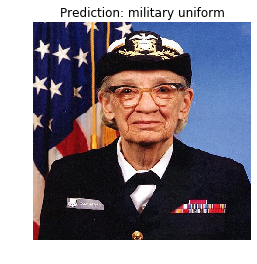

In [11]:
result = classifier_model.predict(grace_hopper[np.newaxis, ...])
result.shape

predicted_class = np.argmax(result[0], axis=-1)
predicted_class

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name)

In [12]:
result_batch = classifier_model.predict(image_batch)

In [13]:
labels_batch = imagenet_labels[np.argmax(result_batch, axis=-1)]
labels_batch

array(['daisy', 'daisy', 'cardoon', 'daisy', 'daisy', 'stretcher',
       'coral fungus', 'pot', 'daisy', 'daisy', 'daisy', 'daisy',
       'cardoon', 'daisy', 'brass', 'daisy', 'daisy', 'daisy', 'binder',
       'daisy', 'daisy', 'vase', 'daisy', 'volcano', 'daisy', 'daisy',
       'daisy', 'daisy', 'daisy', 'sea urchin', 'daisy', 'daisy'],
      dtype='<U30')

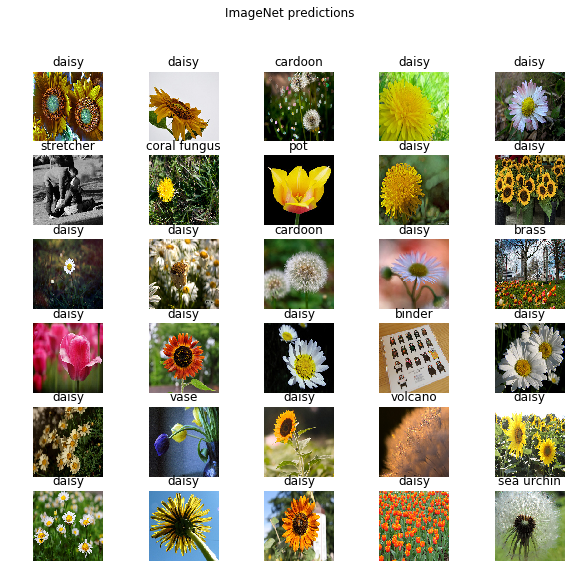

In [15]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [16]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2" #@param {type:"string"}

In [17]:
def feature_extractor(x):
  feature_extractor_module = hub.Module(feature_extractor_url)
  return feature_extractor_module(x)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))

In [18]:
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 5)


In [18]:
features_extractor_layer = layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])

In [19]:
features_extractor_layer.trainable = False

In [20]:
model = tf.keras.Sequential([
  features_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0411 10:34:47.652601 140510498842432 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 6,405
Trainable params: 6,405
Non-trainable params: 0
_________________________________________________________________


In [21]:
init = tf.global_variables_initializer()
sess.run(init)

In [24]:
result = model.predict(image_batch)
result.shape

(32, 5)

In [23]:
model.compile(
  optimizer=tf.train.AdamOptimizer(), 
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [31]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])

NameError: name 'ImageDataGenerator' is not defined

In [32]:
steps_per_epoch = image_data.samples//image_data.batch_size
batch_stats = CollectBatchStats()
model.fit((item for item in image_data), epochs=30, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats])

Epoch 1/30


KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)

In [ ]:
image_data = image_generator.flow_from_directory('flower_photos_splitted/valid', target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break
label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

In [ ]:
result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]
labels_batch

In [ ]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("Model predictions")